# Bioacústica: clasificación de cantos de anfibios con Deep Learning

Este trabajo aplica Redes Neuronales Profundas (DNN), Redes Neuronales Convolucionales (CNN) y Redes LSTM para la **detección automática del anuro *Boana riojana*** a partir de grabaciones bioacústicas.

Se trabajó con **coeficientes MFCC** extraídos de un dataset de **4300 audios**, alcanzando métricas de **exactitud de hasta el 97%**, con precisiones entre **0.89 y 0.97** según el modelo.


Librerias

In [ ]:
#Librerías de operar datos
import numpy as np
import matplotlib.pyplot as plt

#Librerias de MFCC
import librosa
import librosa.display

import os
import glob
import sklearn

#separacion en train,test y validacion
from sklearn.model_selection import train_test_split

#para red neuronal
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

#regularización
from keras import regularizers

#optimizador
from tensorflow.keras.optimizers import Adam

#Cargar modelo
from tensorflow.keras.models import load_model

####
#Convolucional
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

#Early
from tensorflow.keras.callbacks import EarlyStopping




## 1. Preprocesamiento de datos

- **Entrada**: audios de cantos del anuro boana riojana y ruido ambiental convertidos a coeficientes MFCC.  
- **Etapas**: filtrado de calidad, segmentación, balanceo, extracción de coeficientes MFCC y normalización.



In [ ]:
print(f"Cantidad de MFCCs extraídos de Riojana y Sin Riojana 2120+2180= 4300, dio: {len(list_mfccs)}")
print(f"Tamaño de cada MFCC: {list_mfccs[0].shape if len(list_mfccs) > 0 else 'No hay MFCCs procesados'}")

Cantidad de MFCCs extraídos de Riojana y Sin Riojana 2120+2180= 4300, dio: 4300
Tamaño de cada MFCC: (13, 44)


## 2. Entrenamiento del modelo CNN

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

#rere
# ============================
# 📌 Cargar y dividir datos
# ============================
X = np.array(list_mfccs).astype("float32")  # Convertir a float32 para precisión
y = to_categorical(y_label, num_classes=2)  # One-hot encoding

# Separar 70% entrenamiento, 30% temporal
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# Separar 15% validación, 15% prueba
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# ============================
# 📌 Reshape para CNN
# ============================
X_train = X_train.reshape(-1, 13, 44, 1)
X_val = X_val.reshape(-1, 13, 44, 1)
X_test = X_test.reshape(-1, 13, 44, 1)

# ============================
# 📌 Definir modelo CNN con regularización
# ============================
model = Sequential()

# 🔹 CAPA CONVOLUCIONAL 1
model.add(Conv2D(32, (3,3), activation='relu', padding='same',
                 kernel_regularizer=l2(0.0001), input_shape=(13, 44, 1)))  #regularización valor original 0.001
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# 🔹 CAPA CONVOLUCIONAL 2
model.add(Conv2D(64, (3,3), activation='relu', padding='same',
                 kernel_regularizer=l2(0.0001)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# 🔹 CAPA CONVOLUCIONAL 3
model.add(Conv2D(128, (3,3), activation='relu', padding='same',
                 kernel_regularizer=l2(0.0001)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# 🔹 Aplanar y Fully Connected
model.add(Flatten())

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.4))

model.add(Dense(2, activation='softmax'))  # 2 clases

# ============================
# 📌 Compilar modelo
# ============================
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Mostrar resumen del modelo
model.summary()

# ============================
# 📌 Agregar EarlyStopping
# ============================
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# ============================
# 📌 Entrenar modelo
# ============================
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=90,  # Número máximo de épocas
    batch_size=32,# 16 y 32 no hay diferencia ,dejare en 32
    callbacks=[early_stop],  # 📌 Callback agregado
    verbose=1
)

# ============================
# 📌 Evaluar modelo en prueba
# ============================
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Pérdida en prueba: {loss:.4f}, Precisión en prueba: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 13, 44, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 6, 22, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 6, 22, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 6, 22, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 6, 22, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 3, 11, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 3, 11, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 3, 11, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 3, 11, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 1, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 1, 5, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 1, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 175,874 (687.01 KB)

 Trainable params: 175,426 (685.26 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/90
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.5718 - loss: 1.1243 - val_accuracy: 0.7922 - val_loss: 0.6500
Epoch 2/90
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.7289 - loss: 0.7053 - val_accuracy: 0.8248 - val_loss: 0.5064
Epoch 3/90
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.8087 - loss: 0.5164 - val_accuracy: 0.8543 - val_loss: 0.3939
Epoch 4/90
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8326 - loss: 0.4885 - val_accuracy: 0.9070 - val_loss: 0.3078
Epoch 5/90
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8578 - loss: 0.4329 - val_accuracy: 0.9209 - val_loss: 0.2714
Epoch 6/90
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.8871 - loss: 0.3737 - val_accuracy: 0.9333 - val_loss: 0.2638
Epoch 7/90
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.8979 - loss: 0.3641 - val_accuracy: 0.9380 - val_loss: 0.2547
Epoch 8/90
95/95 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9080 - loss: 0.3169 - val_accuracy: 0.9426 -

## 3. Resultados

Se evaluaron: matriz de confusión, accuracy, precisión, sencibilidad y F1.

In [ ]:
#Evaluar el modelo con el conjunto de prueba X_test, y_test
#que son valores que no entrenó la red
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'Precisión en el conjunto de prueba: {test_accuracy}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9724 - loss: 0.1326
Pérdida en el conjunto de prueba: 0.14046567678451538
Precisión en el conjunto de prueba: 0.9705426096916199


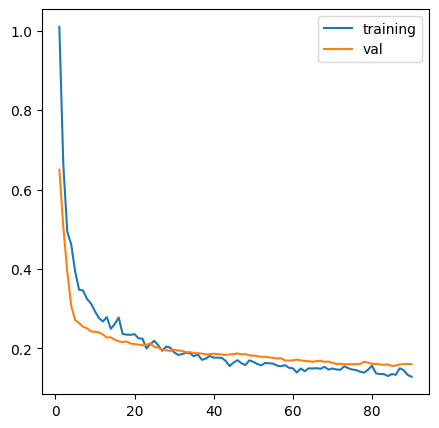

In [ ]:
#GRÁFICA DE LA FUNCIÓN DE COSTO(O FUNCIÓN DE PÉRDIDA), CON DATOS TRAIN Y VALIDACIÓN,
#RESPECTO AL NUMERO DE ITERACIONES O ÉPOCAS
#history.history es un diccionario que almacena la información del entrenamiento
#las claves=métricas registradas,valores=resultados de cada época.
history_dict = history.history
#Pérdida en el conjunto de entrenamiento.
loss_values = history_dict['loss']
#Pérdida en el conjunto de validación.
val_loss_values = history_dict['val_loss']

fig = plt.figure(figsize=(5,5))
epoch = range(1,len(loss_values)+1)
#plt.plot(epoch,loss_values, 'o',label='training')
#plt.plot(epoch,val_loss_values, '--',label='val')
plt.plot(epoch,loss_values, label='training')
plt.plot(epoch,val_loss_values,label='val')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 1️⃣ Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir predicciones a etiquetas
y_test_classes = np.argmax(y_test, axis=1)  # Convertir etiquetas one-hot a índices

# 2️⃣ Calcular la matriz de confusión
cm = confusion_matrix(y_test_classes, y_pred_classes)
print("Matriz de Confusión:")
print(cm)

# 3️⃣ Calcular F1-score, Precisión y Recall,Support
print("\nReporte de Clasificación:")
print(classification_report(y_test_classes, y_pred_classes))

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Matriz de Confusión:
[[345   2]
 [ 17 281]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       347
           1       0.99      0.94      0.97       298

    accuracy                           0.97       645
   macro avg       0.97      0.97      0.97       645
weighted avg       0.97      0.97      0.97       645



## 4. Conclusión  

*  Se clasificaron con éxito los cantos del anuro *Boana riojana* mediante modelos de Deep Learning (DNN, CNN y LSTM).  

*  El modelo CNN alcanzó una exactitud de hasta **97%**, demostrando la eficacia de las técnicas de Deep Learning aplicadas a señales bioacústicas.  

*  Estos resultados evidencian el potencial de la inteligencia artificial para apoyar estudios de biodiversidad y monitoreo acústico de especies.  

